In this notebook we have implemented a Gradient Bandit Algorithm presented in Chapter 2.8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_theme("paper")
%matplotlib inline

In [2]:
num_testbed = 2000
num_armed_bandits = 10
num_experience_steps = 1000

testbed = np.random.normal(size=(num_testbed, num_armed_bandits))

In [3]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def gradient_bandit_algorithm(optimal_value, learned_preference, learning_rate=0.01, 
                              num_learning_iters=1000, use_baseline=False):
    p_optimal_action = []
    average_reward = []
    baseline = 0.0
    best_action = np.argmax(optimal_value)
    num_possible_actions = len(learned_preference)
    # loop by the specified number of iterations
    for learning_iters in range(1, num_learning_iters+1):
        # pre-calculate probabilities and select action
        action_probs = softmax(learned_preference)
        action = np.random.choice(num_possible_actions, p=action_probs)
        p_optimal_action.append(int(action==best_action))
        random_rewards = np.random.normal(loc=optimal_value)
        # incrementally update the baseline 
        baseline += (1/learning_iters) * (random_rewards[action] - baseline)
        # # # 
        for act in range(num_possible_actions):
            if act == action:
                learned_preference[act] += learning_rate * (random_rewards[action] - baseline * int(use_baseline)) * (1 - action_probs[act])
            else:
                learned_preference[act] -= learning_rate * (random_rewards[action] - baseline * int(use_baseline)) * action_probs[act]
        # # # 
        average_reward.append(random_rewards[action])
    return p_optimal_action, average_reward

def run_gba(optimal_values, learned_preferences, learning_rate=0.01,
            num_learning_iters=1000, use_baseline=False):
    percent_optimal_action = []
    average_reward_history = []
    for optimal_value, learned_preference in zip(optimal_values, learned_preferences):
        p_optimal_action, average_reward = gradient_bandit_algorithm(optimal_value, learned_preference, learning_rate, 
                                                                     num_learning_iters, use_baseline)
        percent_optimal_action.append(p_optimal_action)
        average_reward_history.append(average_reward)
    return np.array(percent_optimal_action), np.array(average_reward_history)

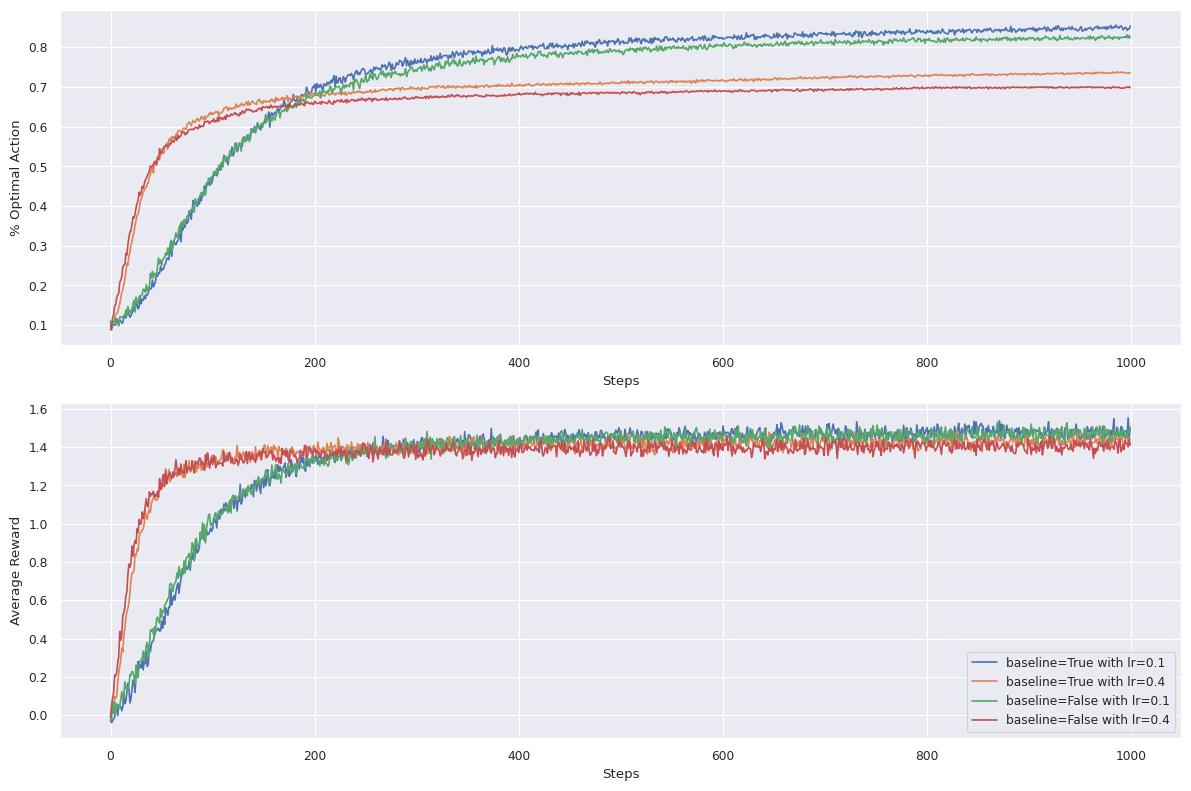

In [4]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

for baseline in [True, False]:
    for lr in [0.1, 0.4]:
        learned_preferences = np.zeros_like(testbed)
        percent_optimal_action, average_reward_history = run_gba(optimal_values=testbed, learned_preferences=learned_preferences,
                                                                 learning_rate=lr, num_learning_iters=num_experience_steps, 
                                                                 use_baseline=baseline)
        # visualizing results over learning steps
        axis[0].plot(np.arange(0, num_experience_steps), np.mean(percent_optimal_action, axis=0, keepdims=True).reshape(-1), 
                    label=f"baseline={baseline} with lr={lr}")
        axis[1].plot(np.arange(0, num_experience_steps), np.mean(average_reward_history, axis=0, keepdims=True).reshape(-1), 
                    label=f"baseline={baseline} with lr={lr}")
    
axis[0].set_xlabel("Steps")
axis[0].set_ylabel("% Optimal Action")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Average Reward")    
fig.tight_layout()
plt.legend()
plt.show()